# Visualizing the manually-curated data
In this notebook, we load some manually-curated data on papers using Diversity Statements, and visualize various aspects of this data.

We did manual searches on Google Scholar for papers that cite the [code](https://scholar.google.com/scholar?cites=9664289398725956584&as_sdt=2005&sciodt=0,5&hl=en) and those that cite the [paper](https://scholar.google.com/scholar?cites=5476688246125765713&as_sdt=2005&sciodt=0,5&hl=en).

We also did a search with opencitations.net to find DOIs of papers that cite the DOI of the [code](https://opencitations.net/index/coci/api/v1/citations/10.5281/zenodo.3672109) and the [paper](https://opencitations.net/index/coci/api/v1/citations/10.1101/2020.01.03.894378).
The search for the code revealed 0 DOIs (maybe they don't track code citations).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3_circles, venn3_unweighted
from matplotlib_venn import _common, _venn3
import matplotlib
import re
import scipy.stats as st
import seaborn as sns
from matplotlib.lines import Line2D


%matplotlib inline

## Load the data
This data was gathered manually from a Google Scholar search for the papers that cite the preprint on this topic:

Dworkin, J. D., Linn, K. A., Teich, E. G., Zurn, P., Shinohara, R. T., & Bassett, D. S. (2020). The extent and drivers of gender imbalance in neuroscience reference lists. arXiv preprint arXiv:2001.01002.

In [2]:
datafile = "../../data/citing_papers__manually_gathered.csv"
df = pd.read_csv(datafile)
df[["mm", "wm", "mw", "ww"]] = df[["mm", "wm", "mw", "ww"]].astype(float)
df.head(2)

,title,bassett_author,arxiv,doi,no_access,diversity_statement,mm,wm,mw,ww
0,(In) citing Action to Realize an Equitable Future,1,0,10.1016/j.neuron.2020.05.011,0,0,NaN,NaN,NaN,NaN
1,A causal study of bumetanide on a marker of ex...,0,0,10.1101/2020.09.22.304279,0,Recent work in several fields of science has i...,69.8,22.6,3.8,3.8


## Notes about the citing papers


In [3]:
print(f"{len(df)} papers were found")

n_papers_w_div_statement = len(df[df.mm >0])
print("%d papers contain a diversity statement" % n_papers_w_div_statement)

# n_preprints = df["preprint"].sum()
# n_articles = len(df) - df["preprint"].sum()
# print(f"{n_preprints} are preprints, {n_articles} journal articles")

n_by_bassett = df["bassett_author"].sum()
n_not_by_bassett = len(df) - n_by_bassett
print(
    f"{n_by_bassett} include Danielle Bassett as an author, {n_not_by_bassett} do not"
)

71 papers were found
49 papers contain a diversity statement
35 include Danielle Bassett as an author, 36 do not


## Visualize the actual percentages
that were reported in the diversity statements

Select data

In [4]:
cols = ["mm", "wm", "mw", "ww"]
df_with_ds = df.loc[df["mm"] > 0, cols]
df_self_cite = df_with_ds.loc[df["bassett_author"] == 1, cols]
df_not_self_cite = df_with_ds.loc[df["bassett_author"] == 0, cols]

Set plotting parameters

In [5]:
matplotlib.rc("font", **{"size": 14})
matplotlib.rc("axes", **{"edgecolor": "grey"})
sns.set_context(rc={"patch.linewidth": 1.5})

self_cite_color = "midnightblue"
self_cite_alpha = 0.5
not_self_cite_color = "chocolate"
not_self_cite_alpha = 0.5
bar_color = "lightgrey"
bar_palette = ["midnightblue", "teal", "skyblue", "chocolate"]
bar_alpha = 0.7

### Reported diversity

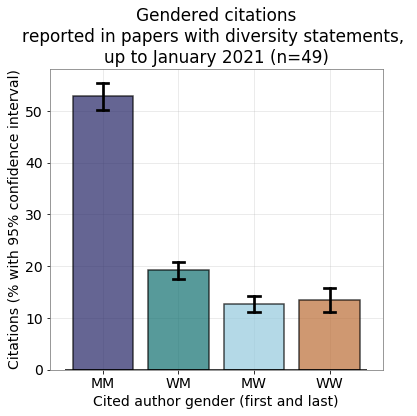

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.barplot(
    data=df_with_ds,
    ci=95,
    palette=bar_palette,
    alpha=bar_alpha,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# labels
ax.set_ylabel("Citations (% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")
plt.title(
    "Gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)

# save
plt.tight_layout()
plt.savefig("../../reports/figures/reported_diversity.png")

### Reported diversity, with swarm overlayed

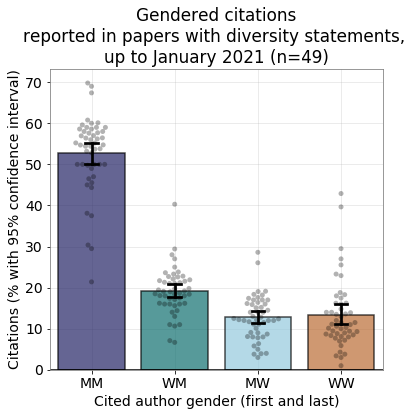

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.swarmplot(data=df_with_ds, color="k", alpha=0.3)
sns.barplot(
    data=df_with_ds,
    ci=95,
    palette=bar_palette,
    alpha=bar_alpha,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# labels
ax.set_ylabel("Citations (% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")
plt.title(
    "Gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)

# save
plt.tight_layout()
plt.savefig("../../reports/figures/reported_diversity__with_swarm.png")

### Reported diversity, with self-citations noticeable

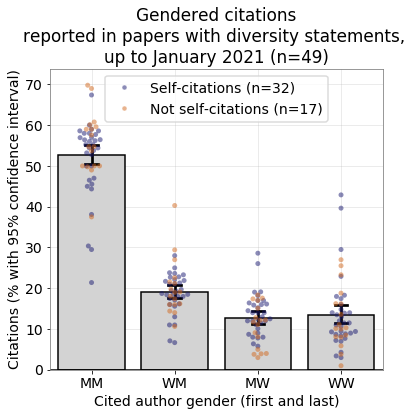

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.swarmplot(data=df_self_cite, color=self_cite_color, alpha=self_cite_alpha)
sns.swarmplot(
    data=df_not_self_cite, color=not_self_cite_color, alpha=not_self_cite_alpha
)
sns.barplot(
    data=df_with_ds,
    ci=95,
    #             palette=bar_palette,
    color="lightgrey",
    alpha=1,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Self-citations (n=%d)" % len(df_self_cite),
        markerfacecolor=self_cite_color,
        alpha=self_cite_alpha,
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Not self-citations (n=%d)" % len(df_not_self_cite),
        markerfacecolor=not_self_cite_color,
        alpha=not_self_cite_alpha,
        markersize=5,
    ),
]
leg = plt.legend(handles=legend_elements, loc="upper center")
leg.get_frame().set_edgecolor("lightgrey")

# labels
ax.set_ylabel("Citations (% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")
plt.title(
    "Gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)

# save
plt.tight_layout()
plt.savefig(
    "../../reports/figures/reported_diversity__with_self_citation_swarm.png"
)

## Calculate and visualize the percentages relative to the benchmarks

Calculate relative percentages and select data

In [9]:
expected_percentages = {
    "mm": 58.4,
    "wm": 25.5,
    "mw": 9.4,
    "ww": 6.7,
}

relative_cols = ["rel_mm", "rel_wm", "rel_mw", "rel_ww"]
for i_col, column in enumerate(list(df_with_ds.columns)):
    col_vals = []
    for index, row in df_with_ds.iterrows():
        col_vals.append(row[column] - expected_percentages[column])
    df_with_ds[relative_cols[i_col]] = col_vals


rel_df_with_ds = df_with_ds[relative_cols]
rel_df_self_cite = df_with_ds.loc[df["bassett_author"] == 1, relative_cols]
rel_df_not_self_cite = df_with_ds.loc[df["bassett_author"] == 0, relative_cols]


### Relative diversity

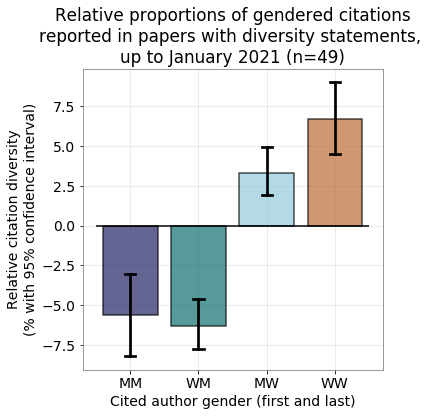

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.barplot(
    data=rel_df_with_ds,
    ci=95,
    palette=bar_palette,
    alpha=bar_alpha,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# labels
ax.set_ylabel("Relative citation diversity\n(% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")
plt.title(
    "Relative proportions of gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)

# save
plt.tight_layout()
plt.savefig("../../reports/figures/relative_diversity.png")

### Reported diversity, with swarm overlayed

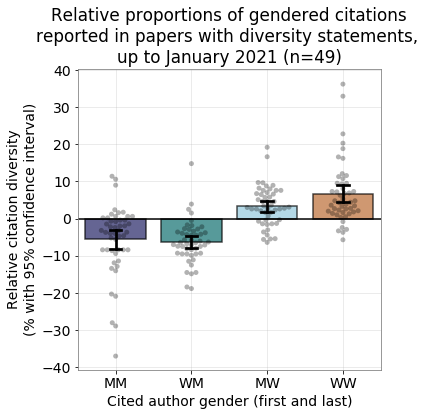

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.swarmplot(data=rel_df_with_ds, color="k", alpha=0.3)
sns.barplot(
    data=rel_df_with_ds,
    ci=95,
    palette=bar_palette,
    alpha=bar_alpha,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# labels
ax.set_ylabel("Relative citation diversity\n(% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")


# save
plt.tight_layout()
plt.savefig("../../reports/figures/relative_diversity__with_swarm.png")


plt.title(
    "Relative proportions of gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)
plt.tight_layout()
plt.savefig("../../reports/figures/relative_diversity__with_swarm__with_title.png")

### Relative diversity, with self-citations noticeable

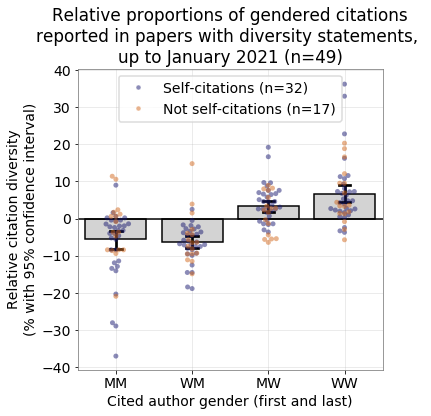

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

# plots
sns.swarmplot(
    data=rel_df_self_cite, color=self_cite_color, alpha=self_cite_alpha
)
sns.swarmplot(
    data=rel_df_not_self_cite,
    color=not_self_cite_color,
    alpha=not_self_cite_alpha,
)
sns.barplot(
    data=rel_df_with_ds,
    ci=95,
    #             palette=bar_palette,
    color="lightgrey",
    alpha=1,
    errcolor="k",
    capsize=0.15,
    edgecolor="k",
)

# grid
plt.grid(alpha=0.3)
ax.hlines(y=0, xmin=-0.5, xmax=3.5)
ax.set_axisbelow(True)

# legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Self-citations (n=%d)" % len(rel_df_self_cite),
        markerfacecolor=self_cite_color,
        alpha=self_cite_alpha,
        markersize=5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Not self-citations (n=%d)" % len(rel_df_not_self_cite),
        markerfacecolor=not_self_cite_color,
        alpha=not_self_cite_alpha,
        markersize=5,
    ),
]
leg = plt.legend(handles=legend_elements, loc="upper center")
leg.get_frame().set_edgecolor("lightgrey")

# labels
ax.set_ylabel("Relative citation diversity\n(% with 95% confidence interval)")
# ticks = ["man\nman", "man\nwoman", "woman\nman", "woman\nwoman"]
ticks = ["MM", "WM", "MW", "WW"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Cited author gender (first and last)")
plt.title(
    "Relative proportions of gendered citations\nreported in papers "
    + f"with diversity statements, \nup to January 2021 (n=%d)"
    % n_papers_w_div_statement
)

# save
plt.tight_layout()
plt.savefig(
    "../../reports/figures/relative_diversity__with_self_citation_swarm.png"
)

# Calculate stats
to check if visualizations are correct

In [13]:
z = 1.96  # for 95% CI
stat_cols = cols + relative_cols
df_stats = pd.DataFrame(columns=df_with_ds.columns)
for column, vals in df_with_ds.iteritems():
    mean = np.mean(vals)  # mean
    st = np.std(vals)  # standard deviation
    n = len(vals)  # sample size
    se = st / np.sqrt(n)  # standard error
    lcb = mean - z * se  # lower limit of CI
    ucb = mean + z * se  # upper limit of CI

    df_stats.loc["Max", column] = np.max(vals)
    df_stats.loc["95% CI upper bound", column] = ucb
    df_stats.loc["Mean", column] = mean
    df_stats.loc["95% CI lower bound", column] = lcb
    df_stats.loc["Min", column] = np.min(vals)

df_stats.to_csv("../../reports/manual_data_stats.csv")
df_stats

,mm,wm,mw,ww,rel_mm,rel_wm,rel_mw,rel_ww
Max,69.8,40.3,28.6,42.9,11.4,14.8,19.2,36.2
95% CI upper bound,55.3893,20.761,14.2069,15.7658,-3.01075,-4.73901,4.80691,9.06577
Mean,52.8045,19.1929,12.7292,13.4202,-5.59551,-6.30714,3.32918,6.7202
95% CI lower bound,50.2197,17.6247,11.2515,11.0746,-8.18027,-7.87528,1.85146,4.37464
Min,21.4,6.67,3,1,-37,-18.83,-6.4,-5.7
